In [1]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf

print(tf.test.is_gpu_available())




Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


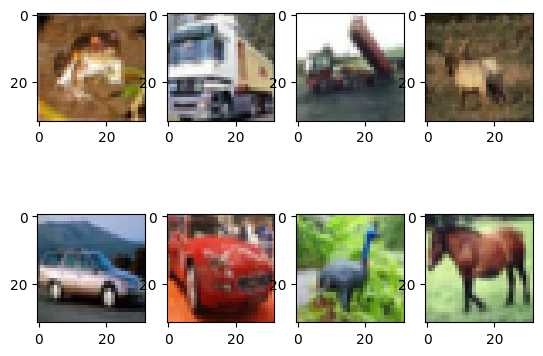

In [3]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [12]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [13]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [14]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [28]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

# write your code here...

def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''

    # Load CIFAR-10 dataset and normalize
    # (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
    # train_images, test_images = train_images / 255.0, test_images / 255.0

    X_train, X_test, y_train, y_test = train_test_split(imgs[0:10000], clean_labels, test_size=0.1, random_state=42)

    model_II = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')  # Assuming 10 classes as in CIFAR-10
    ])

    if os.path.exists('./model_I.h5'):
        models.load_model('./model_I.h5')

        image = np.expand_dims(image, axis=0)

        pred = model_II.predict(image)
        pred = np.squeeze(pred)
        predict_class = np.argmax(pred)

        return predict_class
    else:

        # Compile the improved model
        model_II.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])

        history_II = model_II.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

        test_loss_II, test_acc_II = model_II.evaluate(X_test, y_test, verbose=2)

        print(f"Test Loss: {test_loss_II}, Test Accuracy: {test_acc_II}")

        model_II.save('./model_I.h5')

        image = np.expand_dims(image, axis=0)

        pred = model_II.predict(image)
        pred = np.squeeze(pred)
        predict_class = np.argmax(pred)

        return predict_class

In [27]:
#model1有plt graph的code 需要run出来
def model_I(image):
    '''
    This function should take in the image of dimension 32*32*3 as input and returns a label prediction
    '''

    # Load CIFAR-10 dataset and normalize
    # (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
    # train_images, test_images = train_images / 255.0, test_images / 255.0

    X_train, X_test, y_train, y_test = train_test_split(imgs[0:10000], clean_labels, test_size=0.1, random_state=42)

    model_II = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')  # Assuming 10 classes as in CIFAR-10
    ])

    if os.path.exists('./model_I.h5'):
        models.load_model('./model_I.h5')

        image = np.expand_dims(image, axis=0)

        pred = model_II.predict(image)
        pred = np.squeeze(pred)
        predict_class = np.argmax(pred)

        return predict_class
    else:

        # Compile the improved model
        model_II.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])

        history_II = model_II.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

        test_loss_II, test_acc_II = model_II.evaluate(X_test, y_test, verbose=2)

        print(f"Test Loss: {test_loss_II}, Test Accuracy: {test_acc_II}")

        # Plot training & validation accuracy values
        plt.plot(history_II.history['accuracy'])
        plt.plot(history_II.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        # Plot training & validation loss values
        plt.plot(history_II.history['loss'])
        plt.plot(history_II.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        model_II.save('./model_I.h5')

        image = np.expand_dims(image, axis=0)

        pred = model_II.predict(image)
        pred = np.squeeze(pred)
        predict_class = np.argmax(pred)

        return predict_class

### 2.3. Model II

In [8]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...


def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''

    # Load CIFAR-10 dataset and normalize
    # (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
    # train_images, test_images = train_images / 255.0, test_images / 255.0

    X_train, X_test, y_train, y_test = train_test_split(imgs[0:10000], clean_labels, test_size=0.3, random_state=42)

    # 数据预处理
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # 创建数据增强生成器
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # 对训练集进行数据增强
    datagen.fit(X_train)

    model_II = models.Sequential([
        layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    # model_II=ResNet18()

    if os.path.exists('./model_II.h5'):
        models.load_model('./model_II.h5')

        image = np.expand_dims(image, axis=0)

        pred = model_II.predict(image)
        pred = np.squeeze(pred)
        predict_class = np.argmax(pred)

        return predict_class
    else:

        # Compile the improved model
        # model_II.compile(optimizer='adam',
        #                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        #                  metrics=['accuracy'])

        sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
        model_II.compile(optimizer=sgd_optimizer,
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])

        # history_II = model_II.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))
        model_II.fit(datagen.flow(X_train, y_train, batch_size=32),
                     epochs=100,#这里改epoch
                     validation_data=(X_test, y_test))

        test_loss_II, test_acc_II = model_II.evaluate(X_test, y_test, verbose=2)

        print(f"Test Loss: {test_loss_II}, Test Accuracy: {test_acc_II}")

        model_II.save('./model_II.h5')

        image = np.expand_dims(image, axis=0)

        pred = model_II.predict(image)
        pred = np.squeeze(pred)
        predict_class = np.argmax(pred)

        return predict_class

In [29]:
#Model2的图像，需要run出来
import matplotlib.pyplot as plt

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''

    # Load CIFAR-10 dataset and normalize
    # (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
    # train_images, test_images = train_images / 255.0, test_images / 255.0

    X_train, X_test, y_train, y_test = train_test_split(imgs[0:10000], clean_labels, test_size=0.3, random_state=42)

    # 数据预处理
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # 创建数据增强生成器
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # 对训练集进行数据增强
    datagen.fit(X_train)

    model_II = models.Sequential([
        layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    if os.path.exists('./model_II.h5'):
        models.load_model('./model_II.h5')

        image = np.expand_dims(image, axis=0)

        pred = model_II.predict(image)
        pred = np.squeeze(pred)
        predict_class = np.argmax(pred)

        return predict_class
    else:

        # Compile the improved model
        sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
        model_II.compile(optimizer=sgd_optimizer,
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])

        history_II = model_II.fit(datagen.flow(X_train, y_train, batch_size=32),
                     epochs=100,
                     validation_data=(X_test, y_test))

        test_loss_II, test_acc_II = model_II.evaluate(X_test, y_test, verbose=2)

        print(f"Test Loss: {test_loss_II}, Test Accuracy: {test_acc_II}")

        model_II.save('./model_II.h5')

        image = np.expand_dims(image, axis=0)

        pred = model_II.predict(image)
        pred = np.squeeze(pred)
        predict_class = np.argmax(pred)

        # Plot training & validation accuracy values
        plt.plot(history_II.history['accuracy'])
        plt.plot(history_II.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        # Plot training & validation loss values
        plt.plot(history_II.history['loss'])
        plt.plot(history_II.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        return predict_class

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def model_III(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''

    # Load CIFAR-10 dataset and normalize
    # (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
    # train_images, test_images = train_images / 255.0, test_images / 255.0

    X_train, X_test, y_train, y_test = train_test_split(imgs[0:10000], clean_labels, test_size=0.3, random_state=42)

    # 数据预处理
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # 创建数据增强生成器
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # 对训练集进行数据增强
    datagen.fit(X_train)

    model_II = models.Sequential([
        layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    # model_II=ResNet18()

    if os.path.exists('./model_III.h5'):
        models.load_model('./model_III.h5')

        image = np.expand_dims(image, axis=0)

        pred = model_II.predict(image)
        pred = np.squeeze(pred)
        predict_class = np.argmax(pred)

        return predict_class
    else:

        # Compile the improved model
        # model_II.compile(optimizer='adam',
        #                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        #                  metrics=['accuracy'])

        sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
        model_II.compile(optimizer=sgd_optimizer,
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])

        # history_II = model_II.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))
        model_II.fit(datagen.flow(X_train, y_train, batch_size=32),
                     epochs=500,
                     validation_data=(X_test, y_test))

        test_loss_II, test_acc_II = model_II.evaluate(X_test, y_test, verbose=2)

        print(f"Test Loss: {test_loss_II}, Test Accuracy: {test_acc_II}")

        # model_II.save('./model_II.h5')

        image = np.expand_dims(image, axis=0)

        pred = model_II.predict(image)
        pred = np.squeeze(pred)
        predict_class = np.argmax(pred)

        return predict_class


## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [9]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [11]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 1000
test_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")[:1000]
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    # img_fn = f'../data/test_images/test{i+1:05d}.png'
    img_fn = f'../data/images/{i + 1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(model_II, test_labels, test_imgs)

Epoch 1/100
219/219 [==============================] - 6s 26ms/step - loss: 2.3983 - accuracy: 0.1770 - val_loss: 2.0097 - val_accuracy: 0.2483
Epoch 2/100
219/219 [==============================] - 5s 22ms/step - loss: 2.2064 - accuracy: 0.1793 - val_loss: 2.0885 - val_accuracy: 0.2063
Epoch 3/100
219/219 [==============================] - 5s 21ms/step - loss: 2.1965 - accuracy: 0.1706 - val_loss: 2.0218 - val_accuracy: 0.2563
Epoch 4/100
219/219 [==============================] - 4s 18ms/step - loss: 2.1929 - accuracy: 0.1823 - val_loss: 2.0309 - val_accuracy: 0.2147
Epoch 5/100
219/219 [==============================] - 5s 22ms/step - loss: 2.1656 - accuracy: 0.1961 - val_loss: 2.1194 - val_accuracy: 0.2353
Epoch 6/100
219/219 [==============================] - 4s 18ms/step - loss: 2.1631 - accuracy: 0.2014 - val_loss: 2.1334 - val_accuracy: 0.2057
Epoch 7/100
219/219 [==============================] - 4s 18ms/step - loss: 2.1485 - accuracy: 0.2059 - val_loss: 2.0877 - val_accuracy:

In [10]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 1000
test_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")[:1000]
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    # img_fn = f'../data/test_images/test{i+1:05d}.png'
    img_fn = f'../data/images/{i + 1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(model_II, test_labels, test_imgs)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\James\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100


C:\Users\James\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.2427 - loss: 2.3725 - val_accuracy: 0.4000 - val_loss: 1.6646
Epoch 2/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.3529 - loss: 1.7552 - val_accuracy: 0.4430 - val_loss: 1.6983
Epoch 3/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.4109 - loss: 1.5855 - val_accuracy: 0.5190 - val_loss: 1.3497
Epoch 4/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.4521 - loss: 1.4739 - val_accuracy: 0.4360 - val_loss: 1.7597
Epoch 5/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.4991 - loss: 1.3439 - val_accuracy: 0.5330 - val_loss: 1.3234
Epoch 6/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5452 - loss: 1.2645 - val_accuracy: 0.5560 - val_loss: 1.2803
Epoch 7/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5817 - loss: 1.1621 - val_accuracy: 0.5800 - val_loss: 1.1898
Epoch 8/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.6151 - loss: 1.0741 - val_accurac

Test Loss: 2.9836628437042236, Test Accuracy: 0.6710000038146973
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  0%|                                                                            | 1/1000 [12:19<205:18:10, 739.83s/it]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  0%|▏                                                                            | 2/1000 [12:20<84:32:16, 304.95s/it]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  0%|▏                                                                            | 3/1000 [12:20<45:57:18, 165.94s/it]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  0%|▎                                                                            | 4/1000 [12:21<27:50:21, 100.62s/it]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  0%|▍                                                                             | 5/1000 [12:21<17:50:05, 64.53s/it]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


  1%|▍                                                                             | 6/1000 [12:22<11:48:11, 42.75s/it]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  1%|▌                                                                              | 7/1000 [12:22<7:58:55, 28.94s/it]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|▋                                                                              | 8/1000 [12:23<5:28:42, 19.88s/it]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  1%|▋                                                                              | 9/1000 [12:23<3:48:22, 13.83s/it]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  1%|▊                                                                             | 10/1000 [12:24<2:41:59,  9.82s/it]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  1%|▊                                                                             | 11/1000 [12:25<1:54:55,  6.97s/it]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  1%|▉                                                                             | 12/1000 [12:25<1:22:39,  5.02s/it]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  1%|█                                                                               | 13/1000 [12:26<59:55,  3.64s/it]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  1%|█                                                                               | 14/1000 [12:26<44:19,  2.70s/it]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  2%|█▏                                                                              | 15/1000 [12:27<33:12,  2.02s/it]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  2%|█▎                                                                              | 16/1000 [12:27<25:50,  1.58s/it]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▎                                                                              | 17/1000 [12:28<20:36,  1.26s/it]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  2%|█▍                                                                              | 18/1000 [12:28<16:34,  1.01s/it]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  2%|█▌                                                                              | 19/1000 [12:29<13:46,  1.19it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


  2%|█▌                                                                              | 20/1000 [12:29<12:11,  1.34it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  2%|█▋                                                                              | 21/1000 [12:30<11:03,  1.48it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  2%|█▊                                                                              | 22/1000 [12:30<09:47,  1.66it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


  2%|█▊                                                                              | 23/1000 [12:31<10:40,  1.53it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  2%|█▉                                                                              | 24/1000 [12:31<09:56,  1.64it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  2%|██                                                                              | 25/1000 [12:32<09:18,  1.74it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  3%|██                                                                              | 26/1000 [12:32<09:03,  1.79it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  3%|██▏                                                                             | 27/1000 [12:33<08:30,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  3%|██▏                                                                             | 28/1000 [12:33<08:20,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  3%|██▎                                                                             | 29/1000 [12:34<08:15,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  3%|██▍                                                                             | 30/1000 [12:34<07:57,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  3%|██▍                                                                             | 31/1000 [12:35<08:04,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  3%|██▌                                                                             | 32/1000 [12:35<08:06,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  3%|██▋                                                                             | 33/1000 [12:36<07:50,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  3%|██▋                                                                             | 34/1000 [12:36<07:30,  2.14it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  4%|██▊                                                                             | 35/1000 [12:37<07:46,  2.07it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  4%|██▉                                                                             | 36/1000 [12:37<07:58,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


  4%|██▉                                                                             | 37/1000 [12:38<09:27,  1.70it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


  4%|███                                                                             | 38/1000 [12:39<09:10,  1.75it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  4%|███                                                                             | 39/1000 [12:39<08:54,  1.80it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  4%|███▏                                                                            | 40/1000 [12:40<08:38,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  4%|███▎                                                                            | 41/1000 [12:40<08:21,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  4%|███▎                                                                            | 42/1000 [12:41<08:06,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  4%|███▍                                                                            | 43/1000 [12:41<07:45,  2.06it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  4%|███▌                                                                            | 44/1000 [12:42<07:50,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  4%|███▌                                                                            | 45/1000 [12:42<07:53,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  5%|███▋                                                                            | 46/1000 [12:42<07:35,  2.10it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  5%|███▊                                                                            | 47/1000 [12:43<07:35,  2.09it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


  5%|███▊                                                                            | 48/1000 [12:43<07:49,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


  5%|███▉                                                                            | 49/1000 [12:44<08:14,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  5%|████                                                                            | 50/1000 [12:45<07:59,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


  5%|████                                                                            | 51/1000 [12:45<10:02,  1.58it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  5%|████▏                                                                           | 52/1000 [12:46<09:52,  1.60it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


  5%|████▏                                                                           | 53/1000 [12:47<09:09,  1.72it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


  5%|████▎                                                                           | 54/1000 [12:47<08:55,  1.77it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  6%|████▍                                                                           | 55/1000 [12:48<08:37,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▍                                                                           | 56/1000 [12:48<08:41,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  6%|████▌                                                                           | 57/1000 [12:49<08:46,  1.79it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  6%|████▋                                                                           | 58/1000 [12:49<08:40,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  6%|████▋                                                                           | 59/1000 [12:50<08:32,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  6%|████▊                                                                           | 60/1000 [12:50<08:26,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  6%|████▉                                                                           | 61/1000 [12:51<08:15,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  6%|████▉                                                                           | 62/1000 [12:51<08:13,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  6%|█████                                                                           | 63/1000 [12:52<07:51,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  6%|█████                                                                           | 64/1000 [12:52<07:37,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  6%|█████▏                                                                          | 65/1000 [12:53<07:33,  2.06it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  7%|█████▎                                                                          | 66/1000 [12:54<09:04,  1.72it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


  7%|█████▎                                                                          | 67/1000 [12:54<08:55,  1.74it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  7%|█████▍                                                                          | 68/1000 [12:55<08:33,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  7%|█████▌                                                                          | 69/1000 [12:55<08:23,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  7%|█████▌                                                                          | 70/1000 [12:56<08:13,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  7%|█████▋                                                                          | 71/1000 [12:56<08:08,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  7%|█████▊                                                                          | 72/1000 [12:57<07:48,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  7%|█████▊                                                                          | 73/1000 [12:57<08:06,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  7%|█████▉                                                                          | 74/1000 [12:58<07:55,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  8%|██████                                                                          | 75/1000 [12:58<08:06,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  8%|██████                                                                          | 76/1000 [12:59<08:07,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  8%|██████▏                                                                         | 77/1000 [12:59<08:10,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


  8%|██████▏                                                                         | 78/1000 [13:00<08:00,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  8%|██████▎                                                                         | 79/1000 [13:00<07:50,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


  8%|██████▍                                                                         | 80/1000 [13:01<09:16,  1.65it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  8%|██████▍                                                                         | 81/1000 [13:02<08:40,  1.77it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  8%|██████▌                                                                         | 82/1000 [13:02<08:34,  1.78it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  8%|██████▋                                                                         | 83/1000 [13:03<08:29,  1.80it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  8%|██████▋                                                                         | 84/1000 [13:03<08:02,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  8%|██████▊                                                                         | 85/1000 [13:04<07:51,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  9%|██████▉                                                                         | 86/1000 [13:04<07:28,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  9%|██████▉                                                                         | 87/1000 [13:04<07:10,  2.12it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  9%|███████                                                                         | 88/1000 [13:05<07:25,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  9%|███████                                                                         | 89/1000 [13:05<07:14,  2.10it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  9%|███████▏                                                                        | 90/1000 [13:06<07:25,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  9%|███████▎                                                                        | 91/1000 [13:06<07:28,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  9%|███████▎                                                                        | 92/1000 [13:07<07:33,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  9%|███████▍                                                                        | 93/1000 [13:07<07:33,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


  9%|███████▌                                                                        | 94/1000 [13:08<08:45,  1.72it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 10%|███████▌                                                                        | 95/1000 [13:09<08:24,  1.79it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 10%|███████▋                                                                        | 96/1000 [13:09<08:20,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 10%|███████▊                                                                        | 97/1000 [13:10<08:13,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 10%|███████▊                                                                        | 98/1000 [13:10<08:07,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 10%|███████▉                                                                        | 99/1000 [13:11<07:40,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 10%|███████▉                                                                       | 100/1000 [13:11<07:41,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 10%|███████▉                                                                       | 101/1000 [13:12<07:33,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 10%|████████                                                                       | 102/1000 [13:12<07:17,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 10%|████████▏                                                                      | 103/1000 [13:13<07:22,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 10%|████████▏                                                                      | 104/1000 [13:13<07:31,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 10%|████████▎                                                                      | 105/1000 [13:14<07:18,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 11%|████████▎                                                                      | 106/1000 [13:14<07:18,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 11%|████████▍                                                                      | 107/1000 [13:15<07:01,  2.12it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 11%|████████▌                                                                      | 108/1000 [13:15<08:25,  1.77it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 11%|████████▌                                                                      | 109/1000 [13:16<08:12,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 11%|████████▋                                                                      | 110/1000 [13:16<07:55,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 11%|████████▊                                                                      | 111/1000 [13:17<07:58,  1.86it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 11%|████████▊                                                                      | 112/1000 [13:17<07:49,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 11%|████████▉                                                                      | 113/1000 [13:18<07:49,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|█████████                                                                      | 114/1000 [13:19<07:40,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 12%|█████████                                                                      | 115/1000 [13:19<07:45,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 12%|█████████▏                                                                     | 116/1000 [13:20<07:28,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 12%|█████████▏                                                                     | 117/1000 [13:20<07:28,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 12%|█████████▎                                                                     | 118/1000 [13:21<07:30,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 12%|█████████▍                                                                     | 119/1000 [13:21<07:34,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 12%|█████████▍                                                                     | 120/1000 [13:22<07:44,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 12%|█████████▌                                                                     | 121/1000 [13:22<07:33,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 12%|█████████▋                                                                     | 122/1000 [13:23<08:48,  1.66it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 12%|█████████▋                                                                     | 123/1000 [13:23<08:25,  1.73it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 12%|█████████▊                                                                     | 124/1000 [13:24<08:05,  1.80it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 12%|█████████▉                                                                     | 125/1000 [13:24<07:33,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 13%|█████████▉                                                                     | 126/1000 [13:25<07:35,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 13%|██████████                                                                     | 127/1000 [13:25<07:40,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 13%|██████████                                                                     | 128/1000 [13:26<07:39,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 13%|██████████▏                                                                    | 129/1000 [13:26<07:22,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 13%|██████████▎                                                                    | 130/1000 [13:27<07:10,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 13%|██████████▎                                                                    | 131/1000 [13:27<07:15,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 13%|██████████▍                                                                    | 132/1000 [13:28<07:04,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 13%|██████████▌                                                                    | 133/1000 [13:28<06:47,  2.13it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 13%|██████████▌                                                                    | 134/1000 [13:29<06:51,  2.10it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 14%|██████████▋                                                                    | 135/1000 [13:29<06:52,  2.10it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 14%|██████████▋                                                                    | 136/1000 [13:30<06:54,  2.08it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 14%|██████████▊                                                                    | 137/1000 [13:31<08:12,  1.75it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 14%|██████████▉                                                                    | 138/1000 [13:31<07:38,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 14%|██████████▉                                                                    | 139/1000 [13:32<07:43,  1.86it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 14%|███████████                                                                    | 140/1000 [13:32<07:31,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 14%|███████████▏                                                                   | 141/1000 [13:33<07:22,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 14%|███████████▏                                                                   | 142/1000 [13:33<07:16,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 14%|███████████▎                                                                   | 143/1000 [13:34<07:12,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|███████████▍                                                                   | 144/1000 [13:34<07:16,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 14%|███████████▍                                                                   | 145/1000 [13:35<07:13,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 15%|███████████▌                                                                   | 146/1000 [13:35<06:59,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 15%|███████████▌                                                                   | 147/1000 [13:35<06:54,  2.06it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 15%|███████████▋                                                                   | 148/1000 [13:36<06:58,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 15%|███████████▊                                                                   | 149/1000 [13:36<06:57,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 15%|███████████▊                                                                   | 150/1000 [13:37<07:06,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 15%|███████████▉                                                                   | 151/1000 [13:38<07:59,  1.77it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 15%|████████████                                                                   | 152/1000 [13:38<07:45,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 15%|████████████                                                                   | 153/1000 [13:39<07:23,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 15%|████████████▏                                                                  | 154/1000 [13:39<07:05,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 16%|████████████▏                                                                  | 155/1000 [13:40<07:00,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 16%|████████████▎                                                                  | 156/1000 [13:40<07:01,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 16%|████████████▍                                                                  | 157/1000 [13:41<07:15,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 16%|████████████▍                                                                  | 158/1000 [13:41<07:16,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 16%|████████████▌                                                                  | 159/1000 [13:42<07:16,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 16%|████████████▋                                                                  | 160/1000 [13:42<07:11,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 16%|████████████▋                                                                  | 161/1000 [13:43<07:03,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 16%|████████████▊                                                                  | 162/1000 [13:43<06:54,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 16%|████████████▉                                                                  | 163/1000 [13:44<06:59,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 16%|████████████▉                                                                  | 164/1000 [13:44<06:57,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 16%|█████████████                                                                  | 165/1000 [13:45<08:20,  1.67it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 17%|█████████████                                                                  | 166/1000 [13:46<08:07,  1.71it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 17%|█████████████▏                                                                 | 167/1000 [13:46<07:42,  1.80it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|█████████████▎                                                                 | 168/1000 [13:47<07:34,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 17%|█████████████▎                                                                 | 169/1000 [13:47<07:16,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 17%|█████████████▍                                                                 | 170/1000 [13:47<06:54,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 17%|█████████████▌                                                                 | 171/1000 [13:48<06:54,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 17%|█████████████▌                                                                 | 172/1000 [13:48<06:38,  2.08it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 17%|█████████████▋                                                                 | 173/1000 [13:49<06:50,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 17%|█████████████▋                                                                 | 174/1000 [13:49<06:38,  2.07it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 18%|█████████████▊                                                                 | 175/1000 [13:50<06:30,  2.12it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 18%|█████████████▉                                                                 | 176/1000 [13:50<06:43,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 18%|█████████████▉                                                                 | 177/1000 [13:51<06:49,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 18%|██████████████                                                                 | 178/1000 [13:51<06:50,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 18%|██████████████▏                                                                | 179/1000 [13:52<08:00,  1.71it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 18%|██████████████▏                                                                | 180/1000 [13:53<07:43,  1.77it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 18%|██████████████▎                                                                | 181/1000 [13:53<07:18,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 18%|██████████████▍                                                                | 182/1000 [13:54<07:26,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 18%|██████████████▍                                                                | 183/1000 [13:54<07:21,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 18%|██████████████▌                                                                | 184/1000 [13:55<07:02,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 18%|██████████████▌                                                                | 185/1000 [13:55<07:02,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 19%|██████████████▋                                                                | 186/1000 [13:56<07:09,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 19%|██████████████▊                                                                | 187/1000 [13:56<06:45,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 19%|██████████████▊                                                                | 188/1000 [13:57<06:53,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 19%|██████████████▉                                                                | 189/1000 [13:57<06:38,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 19%|███████████████                                                                | 190/1000 [13:58<06:38,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 19%|███████████████                                                                | 191/1000 [13:58<06:40,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 19%|███████████████▏                                                               | 192/1000 [13:59<06:51,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 19%|███████████████▏                                                               | 193/1000 [14:00<08:02,  1.67it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 19%|███████████████▎                                                               | 194/1000 [14:00<07:21,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 20%|███████████████▍                                                               | 195/1000 [14:01<07:16,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|███████████████▍                                                               | 196/1000 [14:01<07:29,  1.79it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 20%|███████████████▌                                                               | 197/1000 [14:02<07:12,  1.86it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 20%|███████████████▋                                                               | 198/1000 [14:02<07:23,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 20%|███████████████▋                                                               | 199/1000 [14:03<07:08,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 20%|███████████████▊                                                               | 200/1000 [14:03<07:25,  1.80it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 20%|███████████████▉                                                               | 201/1000 [14:04<07:31,  1.77it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 20%|███████████████▉                                                               | 202/1000 [14:04<07:20,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 20%|████████████████                                                               | 203/1000 [14:05<07:01,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 20%|████████████████                                                               | 204/1000 [14:05<06:54,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 20%|████████████████▏                                                              | 205/1000 [14:06<07:07,  1.86it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 21%|████████████████▎                                                              | 206/1000 [14:06<06:59,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 21%|████████████████▎                                                              | 207/1000 [14:07<06:58,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 21%|████████████████▍                                                              | 208/1000 [14:08<08:03,  1.64it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 21%|████████████████▌                                                              | 209/1000 [14:08<07:33,  1.75it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 21%|████████████████▌                                                              | 210/1000 [14:09<07:17,  1.80it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 21%|████████████████▋                                                              | 211/1000 [14:09<07:11,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 21%|████████████████▋                                                              | 212/1000 [14:10<07:08,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 21%|████████████████▊                                                              | 213/1000 [14:10<06:52,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 21%|████████████████▉                                                              | 214/1000 [14:11<06:34,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 22%|████████████████▉                                                              | 215/1000 [14:11<06:40,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 22%|█████████████████                                                              | 216/1000 [14:12<06:51,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 22%|█████████████████▏                                                             | 217/1000 [14:12<06:51,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 22%|█████████████████▏                                                             | 218/1000 [14:13<06:45,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|█████████████████▎                                                             | 219/1000 [14:13<06:26,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 22%|█████████████████▍                                                             | 220/1000 [14:14<06:21,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|█████████████████▍                                                             | 221/1000 [14:14<06:22,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 22%|█████████████████▌                                                             | 222/1000 [14:15<07:14,  1.79it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 22%|█████████████████▌                                                             | 223/1000 [14:16<07:05,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 22%|█████████████████▋                                                             | 224/1000 [14:16<06:58,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 22%|█████████████████▊                                                             | 225/1000 [14:17<06:43,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 23%|█████████████████▊                                                             | 226/1000 [14:17<06:30,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 23%|█████████████████▉                                                             | 227/1000 [14:18<06:30,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 23%|██████████████████                                                             | 228/1000 [14:18<06:23,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 23%|██████████████████                                                             | 229/1000 [14:18<06:11,  2.07it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 23%|██████████████████▏                                                            | 230/1000 [14:19<06:01,  2.13it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 23%|██████████████████▏                                                            | 231/1000 [14:19<05:57,  2.15it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 23%|██████████████████▎                                                            | 232/1000 [14:20<06:13,  2.06it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 23%|██████████████████▍                                                            | 233/1000 [14:20<06:19,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 23%|██████████████████▍                                                            | 234/1000 [14:21<06:22,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 24%|██████████████████▌                                                            | 235/1000 [14:21<06:30,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 24%|██████████████████▋                                                            | 236/1000 [14:22<07:39,  1.66it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 24%|██████████████████▋                                                            | 237/1000 [14:23<07:24,  1.72it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 24%|██████████████████▊                                                            | 238/1000 [14:23<07:01,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 24%|██████████████████▉                                                            | 239/1000 [14:24<06:32,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 24%|██████████████████▉                                                            | 240/1000 [14:24<06:26,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 24%|███████████████████                                                            | 241/1000 [14:25<06:33,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 24%|███████████████████                                                            | 242/1000 [14:25<06:32,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 24%|███████████████████▏                                                           | 243/1000 [14:26<06:36,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 24%|███████████████████▎                                                           | 244/1000 [14:26<06:27,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 24%|███████████████████▎                                                           | 245/1000 [14:27<06:24,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 25%|███████████████████▍                                                           | 246/1000 [14:27<06:26,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 25%|███████████████████▌                                                           | 247/1000 [14:28<06:25,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 25%|███████████████████▌                                                           | 248/1000 [14:28<06:09,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|███████████████████▋                                                           | 249/1000 [14:29<06:07,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 25%|███████████████████▊                                                           | 250/1000 [14:30<07:27,  1.68it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 25%|███████████████████▊                                                           | 251/1000 [14:30<07:02,  1.77it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 25%|███████████████████▉                                                           | 252/1000 [14:31<06:43,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 25%|███████████████████▉                                                           | 253/1000 [14:31<06:20,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|████████████████████                                                           | 254/1000 [14:32<06:34,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 26%|████████████████████▏                                                          | 255/1000 [14:32<06:25,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 26%|████████████████████▏                                                          | 256/1000 [14:33<06:28,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 26%|████████████████████▎                                                          | 257/1000 [14:33<06:28,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 26%|████████████████████▍                                                          | 258/1000 [14:34<06:30,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 26%|████████████████████▍                                                          | 259/1000 [14:34<06:30,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 26%|████████████████████▌                                                          | 260/1000 [14:35<06:23,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 26%|████████████████████▌                                                          | 261/1000 [14:35<06:23,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 26%|████████████████████▋                                                          | 262/1000 [14:36<06:02,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 26%|████████████████████▊                                                          | 263/1000 [14:36<06:16,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 26%|████████████████████▊                                                          | 264/1000 [14:37<07:30,  1.63it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 26%|████████████████████▉                                                          | 265/1000 [14:38<07:04,  1.73it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 27%|█████████████████████                                                          | 266/1000 [14:38<06:38,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 27%|█████████████████████                                                          | 267/1000 [14:38<06:25,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 27%|█████████████████████▏                                                         | 268/1000 [14:39<06:18,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 27%|█████████████████████▎                                                         | 269/1000 [14:40<06:21,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 27%|█████████████████████▎                                                         | 270/1000 [14:40<06:12,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 27%|█████████████████████▍                                                         | 271/1000 [14:40<06:02,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 27%|█████████████████████▍                                                         | 272/1000 [14:41<05:58,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 27%|█████████████████████▌                                                         | 273/1000 [14:41<05:48,  2.09it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 27%|█████████████████████▋                                                         | 274/1000 [14:42<05:59,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 28%|█████████████████████▋                                                         | 275/1000 [14:42<05:51,  2.06it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 28%|█████████████████████▊                                                         | 276/1000 [14:43<05:55,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 28%|█████████████████████▉                                                         | 277/1000 [14:43<05:46,  2.09it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 28%|█████████████████████▉                                                         | 278/1000 [14:44<05:47,  2.08it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|██████████████████████                                                         | 279/1000 [14:45<06:57,  1.73it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 28%|██████████████████████                                                         | 280/1000 [14:45<06:30,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 28%|██████████████████████▏                                                        | 281/1000 [14:46<06:10,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 28%|██████████████████████▎                                                        | 282/1000 [14:46<06:11,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 28%|██████████████████████▎                                                        | 283/1000 [14:47<06:18,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 28%|██████████████████████▍                                                        | 284/1000 [14:47<06:27,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 28%|██████████████████████▌                                                        | 285/1000 [14:48<06:21,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 29%|██████████████████████▌                                                        | 286/1000 [14:48<06:00,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 29%|██████████████████████▋                                                        | 287/1000 [14:49<05:53,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 29%|██████████████████████▊                                                        | 288/1000 [14:49<06:04,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 29%|██████████████████████▊                                                        | 289/1000 [14:50<06:08,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 29%|██████████████████████▉                                                        | 290/1000 [14:50<05:56,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 29%|██████████████████████▉                                                        | 291/1000 [14:51<05:53,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 29%|███████████████████████                                                        | 292/1000 [14:51<05:46,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 29%|███████████████████████▏                                                       | 293/1000 [14:52<07:00,  1.68it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 29%|███████████████████████▏                                                       | 294/1000 [14:52<06:34,  1.79it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 30%|███████████████████████▎                                                       | 295/1000 [14:53<06:21,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 30%|███████████████████████▍                                                       | 296/1000 [14:53<06:22,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 30%|███████████████████████▍                                                       | 297/1000 [14:54<06:08,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 30%|███████████████████████▌                                                       | 298/1000 [14:54<06:06,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 30%|███████████████████████▌                                                       | 299/1000 [14:55<06:22,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 30%|███████████████████████▋                                                       | 300/1000 [14:56<06:14,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 30%|███████████████████████▊                                                       | 301/1000 [14:56<06:09,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 30%|███████████████████████▊                                                       | 302/1000 [14:57<06:14,  1.86it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 30%|███████████████████████▉                                                       | 303/1000 [14:57<06:01,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 30%|████████████████████████                                                       | 304/1000 [14:58<05:47,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 30%|████████████████████████                                                       | 305/1000 [14:58<06:00,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 31%|████████████████████████▏                                                      | 306/1000 [14:59<06:01,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 31%|████████████████████████▎                                                      | 307/1000 [15:00<07:04,  1.63it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 31%|████████████████████████▎                                                      | 308/1000 [15:00<06:35,  1.75it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 31%|████████████████████████▍                                                      | 309/1000 [15:00<06:18,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 31%|████████████████████████▍                                                      | 310/1000 [15:01<06:12,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 31%|████████████████████████▌                                                      | 311/1000 [15:01<05:57,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 31%|████████████████████████▋                                                      | 312/1000 [15:02<05:44,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 31%|████████████████████████▋                                                      | 313/1000 [15:02<05:37,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 31%|████████████████████████▊                                                      | 314/1000 [15:03<05:41,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 32%|████████████████████████▉                                                      | 315/1000 [15:03<05:46,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 32%|████████████████████████▉                                                      | 316/1000 [15:04<05:47,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 32%|█████████████████████████                                                      | 317/1000 [15:04<05:33,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 32%|█████████████████████████                                                      | 318/1000 [15:05<05:45,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 32%|█████████████████████████▏                                                     | 319/1000 [15:05<05:49,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 32%|█████████████████████████▎                                                     | 320/1000 [15:06<05:54,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


 32%|█████████████████████████▎                                                     | 321/1000 [15:07<07:02,  1.61it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 32%|█████████████████████████▍                                                     | 322/1000 [15:07<06:35,  1.72it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 32%|█████████████████████████▌                                                     | 323/1000 [15:08<06:19,  1.78it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 32%|█████████████████████████▌                                                     | 324/1000 [15:08<06:07,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 32%|█████████████████████████▋                                                     | 325/1000 [15:09<06:00,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 33%|█████████████████████████▊                                                     | 326/1000 [15:09<05:42,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 33%|█████████████████████████▊                                                     | 327/1000 [15:10<05:47,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 33%|█████████████████████████▉                                                     | 328/1000 [15:10<05:34,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 33%|█████████████████████████▉                                                     | 329/1000 [15:11<05:40,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 33%|██████████████████████████                                                     | 330/1000 [15:11<05:28,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 33%|██████████████████████████▏                                                    | 331/1000 [15:12<05:16,  2.11it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 33%|██████████████████████████▏                                                    | 332/1000 [15:12<05:15,  2.12it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 33%|██████████████████████████▎                                                    | 333/1000 [15:13<05:19,  2.09it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 33%|██████████████████████████▍                                                    | 334/1000 [15:13<05:26,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 34%|██████████████████████████▍                                                    | 335/1000 [15:14<06:12,  1.78it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 34%|██████████████████████████▌                                                    | 336/1000 [15:14<06:11,  1.79it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 34%|██████████████████████████▌                                                    | 337/1000 [15:15<06:03,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 34%|██████████████████████████▋                                                    | 338/1000 [15:16<05:58,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 34%|██████████████████████████▊                                                    | 339/1000 [15:16<05:52,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 34%|██████████████████████████▊                                                    | 340/1000 [15:17<05:40,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|██████████████████████████▉                                                    | 341/1000 [15:17<05:34,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 34%|███████████████████████████                                                    | 342/1000 [15:17<05:20,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 34%|███████████████████████████                                                    | 343/1000 [15:18<05:22,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 34%|███████████████████████████▏                                                   | 344/1000 [15:18<05:19,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 34%|███████████████████████████▎                                                   | 345/1000 [15:19<05:19,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 35%|███████████████████████████▎                                                   | 346/1000 [15:19<05:25,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 35%|███████████████████████████▍                                                   | 347/1000 [15:20<05:31,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 35%|███████████████████████████▍                                                   | 348/1000 [15:20<05:22,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 35%|███████████████████████████▌                                                   | 349/1000 [15:21<05:29,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 35%|███████████████████████████▋                                                   | 350/1000 [15:22<06:37,  1.64it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 35%|███████████████████████████▋                                                   | 351/1000 [15:22<06:19,  1.71it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 35%|███████████████████████████▊                                                   | 352/1000 [15:23<06:04,  1.78it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 35%|███████████████████████████▉                                                   | 353/1000 [15:23<05:58,  1.80it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 35%|███████████████████████████▉                                                   | 354/1000 [15:24<05:54,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 36%|████████████████████████████                                                   | 355/1000 [15:24<05:55,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 36%|████████████████████████████                                                   | 356/1000 [15:25<05:35,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 36%|████████████████████████████▏                                                  | 357/1000 [15:25<05:37,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 36%|████████████████████████████▎                                                  | 358/1000 [15:26<05:28,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 36%|████████████████████████████▎                                                  | 359/1000 [15:26<05:30,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 36%|████████████████████████████▍                                                  | 360/1000 [15:27<05:27,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 36%|████████████████████████████▌                                                  | 361/1000 [15:27<05:25,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 36%|████████████████████████████▌                                                  | 362/1000 [15:28<05:39,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 36%|████████████████████████████▋                                                  | 363/1000 [15:29<05:27,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 36%|████████████████████████████▊                                                  | 364/1000 [15:29<06:19,  1.67it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 36%|████████████████████████████▊                                                  | 365/1000 [15:30<05:57,  1.78it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 37%|████████████████████████████▉                                                  | 366/1000 [15:30<05:43,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 37%|████████████████████████████▉                                                  | 367/1000 [15:31<05:31,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 37%|█████████████████████████████                                                  | 368/1000 [15:31<05:19,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 37%|█████████████████████████████▏                                                 | 369/1000 [15:32<05:26,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 37%|█████████████████████████████▏                                                 | 370/1000 [15:32<05:32,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 37%|█████████████████████████████▎                                                 | 371/1000 [15:33<05:30,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 37%|█████████████████████████████▍                                                 | 372/1000 [15:33<05:23,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 37%|█████████████████████████████▍                                                 | 373/1000 [15:34<05:27,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 37%|█████████████████████████████▌                                                 | 374/1000 [15:34<05:18,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 38%|█████████████████████████████▋                                                 | 375/1000 [15:35<05:08,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|█████████████████████████████▋                                                 | 376/1000 [15:35<04:56,  2.11it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 38%|█████████████████████████████▊                                                 | 377/1000 [15:36<05:07,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 38%|█████████████████████████████▊                                                 | 378/1000 [15:37<06:04,  1.71it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 38%|█████████████████████████████▉                                                 | 379/1000 [15:37<05:43,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 38%|██████████████████████████████                                                 | 380/1000 [15:38<05:39,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|██████████████████████████████                                                 | 381/1000 [15:38<05:34,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 38%|██████████████████████████████▏                                                | 382/1000 [15:39<05:31,  1.86it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 38%|██████████████████████████████▎                                                | 383/1000 [15:39<05:28,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|██████████████████████████████▎                                                | 384/1000 [15:40<05:26,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|██████████████████████████████▍                                                | 385/1000 [15:40<05:23,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 39%|██████████████████████████████▍                                                | 386/1000 [15:41<05:14,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 39%|██████████████████████████████▌                                                | 387/1000 [15:41<05:09,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 39%|██████████████████████████████▋                                                | 388/1000 [15:42<05:09,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 39%|██████████████████████████████▋                                                | 389/1000 [15:42<05:19,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 39%|██████████████████████████████▊                                                | 390/1000 [15:43<05:19,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 39%|██████████████████████████████▉                                                | 391/1000 [15:43<05:18,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 39%|██████████████████████████████▉                                                | 392/1000 [15:44<06:02,  1.68it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 39%|███████████████████████████████                                                | 393/1000 [15:45<05:47,  1.75it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 39%|███████████████████████████████▏                                               | 394/1000 [15:45<05:32,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 40%|███████████████████████████████▏                                               | 395/1000 [15:46<05:28,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 40%|███████████████████████████████▎                                               | 396/1000 [15:46<05:25,  1.86it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 40%|███████████████████████████████▎                                               | 397/1000 [15:47<05:31,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 40%|███████████████████████████████▍                                               | 398/1000 [15:47<05:35,  1.79it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 40%|███████████████████████████████▌                                               | 399/1000 [15:48<05:30,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 40%|███████████████████████████████▌                                               | 400/1000 [15:48<05:24,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 40%|███████████████████████████████▋                                               | 401/1000 [15:49<05:20,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 40%|███████████████████████████████▊                                               | 402/1000 [15:49<05:10,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 40%|███████████████████████████████▊                                               | 403/1000 [15:50<05:01,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 40%|███████████████████████████████▉                                               | 404/1000 [15:50<05:01,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 40%|███████████████████████████████▉                                               | 405/1000 [15:51<04:56,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 41%|████████████████████████████████                                               | 406/1000 [15:52<05:45,  1.72it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 41%|████████████████████████████████▏                                              | 407/1000 [15:52<05:37,  1.75it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 41%|████████████████████████████████▏                                              | 408/1000 [15:53<05:31,  1.78it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 41%|████████████████████████████████▎                                              | 409/1000 [15:53<05:30,  1.79it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 41%|████████████████████████████████▍                                              | 410/1000 [15:54<05:20,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 41%|████████████████████████████████▍                                              | 411/1000 [15:54<05:22,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 41%|████████████████████████████████▌                                              | 412/1000 [15:55<05:28,  1.79it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 41%|████████████████████████████████▋                                              | 413/1000 [15:55<05:20,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 41%|████████████████████████████████▋                                              | 414/1000 [15:56<05:10,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 42%|████████████████████████████████▊                                              | 415/1000 [15:56<05:07,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 42%|████████████████████████████████▊                                              | 416/1000 [15:57<05:11,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 42%|████████████████████████████████▉                                              | 417/1000 [15:57<04:57,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 42%|█████████████████████████████████                                              | 418/1000 [15:58<04:45,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 42%|█████████████████████████████████                                              | 419/1000 [15:58<04:44,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 42%|█████████████████████████████████▏                                             | 420/1000 [15:59<04:44,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 42%|█████████████████████████████████▎                                             | 421/1000 [16:00<05:29,  1.76it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 42%|█████████████████████████████████▎                                             | 422/1000 [16:00<05:20,  1.80it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 42%|█████████████████████████████████▍                                             | 423/1000 [16:01<05:06,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 42%|█████████████████████████████████▍                                             | 424/1000 [16:01<05:08,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 42%|█████████████████████████████████▌                                             | 425/1000 [16:02<05:09,  1.86it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 43%|█████████████████████████████████▋                                             | 426/1000 [16:02<05:00,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 43%|█████████████████████████████████▋                                             | 427/1000 [16:03<04:53,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|█████████████████████████████████▊                                             | 428/1000 [16:03<04:54,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 43%|█████████████████████████████████▉                                             | 429/1000 [16:04<04:49,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|█████████████████████████████████▉                                             | 430/1000 [16:04<04:56,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 43%|██████████████████████████████████                                             | 431/1000 [16:05<04:54,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|██████████████████████████████████▏                                            | 432/1000 [16:05<04:42,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 43%|██████████████████████████████████▏                                            | 433/1000 [16:06<04:51,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 43%|██████████████████████████████████▎                                            | 434/1000 [16:06<04:55,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 44%|██████████████████████████████████▎                                            | 435/1000 [16:07<05:56,  1.58it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 44%|██████████████████████████████████▍                                            | 436/1000 [16:08<05:34,  1.69it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|██████████████████████████████████▌                                            | 437/1000 [16:08<05:07,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 44%|██████████████████████████████████▌                                            | 438/1000 [16:09<05:07,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 44%|██████████████████████████████████▋                                            | 439/1000 [16:09<05:05,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 44%|██████████████████████████████████▊                                            | 440/1000 [16:10<05:00,  1.86it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 44%|██████████████████████████████████▊                                            | 441/1000 [16:10<05:09,  1.80it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 44%|██████████████████████████████████▉                                            | 442/1000 [16:11<04:57,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 44%|██████████████████████████████████▉                                            | 443/1000 [16:11<04:54,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 44%|███████████████████████████████████                                            | 444/1000 [16:12<04:56,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 44%|███████████████████████████████████▏                                           | 445/1000 [16:12<04:49,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 45%|███████████████████████████████████▏                                           | 446/1000 [16:13<04:49,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 45%|███████████████████████████████████▎                                           | 447/1000 [16:13<04:53,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 45%|███████████████████████████████████▍                                           | 448/1000 [16:14<04:42,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 45%|███████████████████████████████████▍                                           | 449/1000 [16:15<05:24,  1.70it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 45%|███████████████████████████████████▌                                           | 450/1000 [16:15<05:12,  1.76it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 45%|███████████████████████████████████▋                                           | 451/1000 [16:16<05:01,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 45%|███████████████████████████████████▋                                           | 452/1000 [16:16<04:43,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 45%|███████████████████████████████████▊                                           | 453/1000 [16:17<04:37,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 45%|███████████████████████████████████▊                                           | 454/1000 [16:17<04:56,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 46%|███████████████████████████████████▉                                           | 455/1000 [16:18<04:47,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 46%|████████████████████████████████████                                           | 456/1000 [16:18<04:57,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 46%|████████████████████████████████████                                           | 457/1000 [16:19<04:52,  1.86it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 46%|████████████████████████████████████▏                                          | 458/1000 [16:19<04:54,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 46%|████████████████████████████████████▎                                          | 459/1000 [16:20<04:48,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 46%|████████████████████████████████████▎                                          | 460/1000 [16:20<04:36,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 46%|████████████████████████████████████▍                                          | 461/1000 [16:21<04:31,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|████████████████████████████████████▍                                          | 462/1000 [16:21<04:30,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 46%|████████████████████████████████████▌                                          | 463/1000 [16:22<05:10,  1.73it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 46%|████████████████████████████████████▋                                          | 464/1000 [16:23<04:47,  1.86it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 46%|████████████████████████████████████▋                                          | 465/1000 [16:23<04:46,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 47%|████████████████████████████████████▊                                          | 466/1000 [16:24<04:44,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 47%|████████████████████████████████████▉                                          | 467/1000 [16:24<04:38,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 47%|████████████████████████████████████▉                                          | 468/1000 [16:25<04:47,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|█████████████████████████████████████                                          | 469/1000 [16:25<04:42,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 47%|█████████████████████████████████████▏                                         | 470/1000 [16:26<04:35,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 47%|█████████████████████████████████████▏                                         | 471/1000 [16:26<04:27,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 47%|█████████████████████████████████████▎                                         | 472/1000 [16:27<04:25,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 47%|█████████████████████████████████████▎                                         | 473/1000 [16:27<04:31,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|█████████████████████████████████████▍                                         | 474/1000 [16:28<04:20,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 48%|█████████████████████████████████████▌                                         | 475/1000 [16:28<04:24,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 48%|█████████████████████████████████████▌                                         | 476/1000 [16:29<04:38,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 48%|█████████████████████████████████████▋                                         | 477/1000 [16:30<05:20,  1.63it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 48%|█████████████████████████████████████▊                                         | 478/1000 [16:30<04:54,  1.77it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|█████████████████████████████████████▊                                         | 479/1000 [16:30<04:33,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 48%|█████████████████████████████████████▉                                         | 480/1000 [16:31<04:18,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 48%|█████████████████████████████████████▉                                         | 481/1000 [16:31<04:08,  2.09it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 48%|██████████████████████████████████████                                         | 482/1000 [16:32<04:00,  2.15it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 48%|██████████████████████████████████████▏                                        | 483/1000 [16:32<03:56,  2.19it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 48%|██████████████████████████████████████▏                                        | 484/1000 [16:33<03:52,  2.22it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 48%|██████████████████████████████████████▎                                        | 485/1000 [16:33<03:50,  2.23it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 49%|██████████████████████████████████████▍                                        | 486/1000 [16:34<03:48,  2.25it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 49%|██████████████████████████████████████▍                                        | 487/1000 [16:34<03:50,  2.22it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 49%|██████████████████████████████████████▌                                        | 488/1000 [16:34<03:49,  2.23it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 49%|██████████████████████████████████████▋                                        | 489/1000 [16:35<03:50,  2.22it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 49%|██████████████████████████████████████▋                                        | 490/1000 [16:35<03:52,  2.20it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 49%|██████████████████████████████████████▊                                        | 491/1000 [16:36<03:54,  2.17it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 49%|██████████████████████████████████████▊                                        | 492/1000 [16:37<04:38,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 49%|██████████████████████████████████████▉                                        | 493/1000 [16:37<04:20,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 49%|███████████████████████████████████████                                        | 494/1000 [16:37<04:15,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|███████████████████████████████████████                                        | 495/1000 [16:38<04:06,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 50%|███████████████████████████████████████▏                                       | 496/1000 [16:38<04:00,  2.10it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 50%|███████████████████████████████████████▎                                       | 497/1000 [16:39<03:57,  2.11it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 50%|███████████████████████████████████████▎                                       | 498/1000 [16:39<03:54,  2.14it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 50%|███████████████████████████████████████▍                                       | 499/1000 [16:40<03:53,  2.14it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 50%|███████████████████████████████████████▌                                       | 500/1000 [16:40<03:49,  2.18it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 50%|███████████████████████████████████████▌                                       | 501/1000 [16:41<03:48,  2.18it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|███████████████████████████████████████▋                                       | 502/1000 [16:41<03:46,  2.20it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 50%|███████████████████████████████████████▋                                       | 503/1000 [16:42<03:48,  2.18it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 50%|███████████████████████████████████████▊                                       | 504/1000 [16:42<03:47,  2.18it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 50%|███████████████████████████████████████▉                                       | 505/1000 [16:42<03:46,  2.19it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 51%|███████████████████████████████████████▉                                       | 506/1000 [16:43<04:30,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 51%|████████████████████████████████████████                                       | 507/1000 [16:44<04:32,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 51%|████████████████████████████████████████▏                                      | 508/1000 [16:44<04:20,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 51%|████████████████████████████████████████▏                                      | 509/1000 [16:45<04:09,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 51%|████████████████████████████████████████▎                                      | 510/1000 [16:45<03:59,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 51%|████████████████████████████████████████▎                                      | 511/1000 [16:46<03:53,  2.09it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 51%|████████████████████████████████████████▍                                      | 512/1000 [16:46<03:50,  2.12it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 51%|████████████████████████████████████████▌                                      | 513/1000 [16:47<03:46,  2.15it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 51%|████████████████████████████████████████▌                                      | 514/1000 [16:47<03:43,  2.18it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 52%|████████████████████████████████████████▋                                      | 515/1000 [16:47<03:41,  2.19it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 52%|████████████████████████████████████████▊                                      | 516/1000 [16:48<03:39,  2.21it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 52%|████████████████████████████████████████▊                                      | 517/1000 [16:48<03:36,  2.24it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 52%|████████████████████████████████████████▉                                      | 518/1000 [16:49<03:33,  2.26it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 52%|█████████████████████████████████████████                                      | 519/1000 [16:49<03:34,  2.24it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 52%|█████████████████████████████████████████                                      | 520/1000 [16:50<04:19,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 52%|█████████████████████████████████████████▏                                     | 521/1000 [16:50<04:06,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 52%|█████████████████████████████████████████▏                                     | 522/1000 [16:51<04:01,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 52%|█████████████████████████████████████████▎                                     | 523/1000 [16:51<03:53,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 52%|█████████████████████████████████████████▍                                     | 524/1000 [16:52<03:45,  2.11it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 52%|█████████████████████████████████████████▍                                     | 525/1000 [16:52<03:41,  2.14it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 53%|█████████████████████████████████████████▌                                     | 526/1000 [16:53<03:38,  2.17it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 53%|█████████████████████████████████████████▋                                     | 527/1000 [16:53<03:34,  2.21it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 53%|█████████████████████████████████████████▋                                     | 528/1000 [16:54<03:30,  2.24it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 53%|█████████████████████████████████████████▊                                     | 529/1000 [16:54<03:30,  2.24it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 53%|█████████████████████████████████████████▊                                     | 530/1000 [16:54<03:29,  2.25it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 53%|█████████████████████████████████████████▉                                     | 531/1000 [16:55<03:28,  2.25it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 53%|██████████████████████████████████████████                                     | 532/1000 [16:55<03:29,  2.23it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 53%|██████████████████████████████████████████                                     | 533/1000 [16:56<03:29,  2.23it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 53%|██████████████████████████████████████████▏                                    | 534/1000 [16:57<04:14,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 54%|██████████████████████████████████████████▎                                    | 535/1000 [16:57<04:01,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 54%|██████████████████████████████████████████▎                                    | 536/1000 [16:58<03:57,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 54%|██████████████████████████████████████████▍                                    | 537/1000 [16:58<04:04,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 54%|██████████████████████████████████████████▌                                    | 538/1000 [16:59<04:06,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 54%|██████████████████████████████████████████▌                                    | 539/1000 [16:59<04:05,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 54%|██████████████████████████████████████████▋                                    | 540/1000 [17:00<03:58,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 54%|██████████████████████████████████████████▋                                    | 541/1000 [17:00<03:49,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 54%|██████████████████████████████████████████▊                                    | 542/1000 [17:01<03:45,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 54%|██████████████████████████████████████████▉                                    | 543/1000 [17:01<03:47,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 54%|██████████████████████████████████████████▉                                    | 544/1000 [17:02<03:39,  2.08it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 55%|███████████████████████████████████████████                                    | 545/1000 [17:02<03:35,  2.11it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 55%|███████████████████████████████████████████▏                                   | 546/1000 [17:02<03:32,  2.13it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 55%|███████████████████████████████████████████▏                                   | 547/1000 [17:03<03:42,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


 55%|███████████████████████████████████████████▎                                   | 548/1000 [17:04<04:24,  1.71it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 55%|███████████████████████████████████████████▎                                   | 549/1000 [17:04<04:07,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 55%|███████████████████████████████████████████▍                                   | 550/1000 [17:05<04:08,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 55%|███████████████████████████████████████████▌                                   | 551/1000 [17:05<03:55,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 55%|███████████████████████████████████████████▌                                   | 552/1000 [17:06<03:45,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 55%|███████████████████████████████████████████▋                                   | 553/1000 [17:06<03:37,  2.06it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 55%|███████████████████████████████████████████▊                                   | 554/1000 [17:07<03:34,  2.08it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 56%|███████████████████████████████████████████▊                                   | 555/1000 [17:07<03:35,  2.07it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 56%|███████████████████████████████████████████▉                                   | 556/1000 [17:08<03:32,  2.09it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 56%|████████████████████████████████████████████                                   | 557/1000 [17:08<03:27,  2.13it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 56%|████████████████████████████████████████████                                   | 558/1000 [17:08<03:22,  2.18it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 56%|████████████████████████████████████████████▏                                  | 559/1000 [17:09<03:21,  2.19it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 56%|████████████████████████████████████████████▏                                  | 560/1000 [17:09<03:20,  2.19it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 56%|████████████████████████████████████████████▎                                  | 561/1000 [17:10<03:19,  2.20it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 56%|████████████████████████████████████████████▍                                  | 562/1000 [17:10<03:18,  2.21it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 56%|████████████████████████████████████████████▍                                  | 563/1000 [17:11<03:58,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 56%|████████████████████████████████████████████▌                                  | 564/1000 [17:12<03:46,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 56%|████████████████████████████████████████████▋                                  | 565/1000 [17:12<03:36,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 57%|████████████████████████████████████████████▋                                  | 566/1000 [17:12<03:31,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 57%|████████████████████████████████████████████▊                                  | 567/1000 [17:13<03:26,  2.10it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 57%|████████████████████████████████████████████▊                                  | 568/1000 [17:13<03:24,  2.12it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 57%|████████████████████████████████████████████▉                                  | 569/1000 [17:14<03:20,  2.15it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 57%|█████████████████████████████████████████████                                  | 570/1000 [17:14<03:22,  2.12it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 57%|█████████████████████████████████████████████                                  | 571/1000 [17:15<03:21,  2.12it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [17:15<03:17,  2.16it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [17:16<03:16,  2.17it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [17:16<03:16,  2.17it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [17:17<03:15,  2.17it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [17:17<03:13,  2.19it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [17:18<03:51,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [17:18<03:38,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [17:19<03:29,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [17:19<03:24,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [17:20<03:20,  2.09it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [17:20<03:19,  2.09it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 58%|██████████████████████████████████████████████                                 | 583/1000 [17:21<03:14,  2.15it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 58%|██████████████████████████████████████████████▏                                | 584/1000 [17:21<03:14,  2.14it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 58%|██████████████████████████████████████████████▏                                | 585/1000 [17:21<03:10,  2.17it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 59%|██████████████████████████████████████████████▎                                | 586/1000 [17:22<03:13,  2.14it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 59%|██████████████████████████████████████████████▎                                | 587/1000 [17:22<03:20,  2.06it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 59%|██████████████████████████████████████████████▍                                | 588/1000 [17:23<03:15,  2.11it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 59%|██████████████████████████████████████████████▌                                | 589/1000 [17:23<03:12,  2.14it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 59%|██████████████████████████████████████████████▌                                | 590/1000 [17:24<03:09,  2.16it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 59%|██████████████████████████████████████████████▋                                | 591/1000 [17:25<03:48,  1.79it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 59%|██████████████████████████████████████████████▊                                | 592/1000 [17:25<03:34,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 59%|██████████████████████████████████████████████▊                                | 593/1000 [17:25<03:27,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 59%|██████████████████████████████████████████████▉                                | 594/1000 [17:26<03:24,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 60%|███████████████████████████████████████████████                                | 595/1000 [17:26<03:23,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 60%|███████████████████████████████████████████████                                | 596/1000 [17:27<03:24,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 60%|███████████████████████████████████████████████▏                               | 597/1000 [17:27<03:20,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 60%|███████████████████████████████████████████████▏                               | 598/1000 [17:28<03:18,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 60%|███████████████████████████████████████████████▎                               | 599/1000 [17:28<03:14,  2.06it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 60%|███████████████████████████████████████████████▍                               | 600/1000 [17:29<03:11,  2.09it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 60%|███████████████████████████████████████████████▍                               | 601/1000 [17:29<03:07,  2.13it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 60%|███████████████████████████████████████████████▌                               | 602/1000 [17:30<03:04,  2.15it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 60%|███████████████████████████████████████████████▋                               | 603/1000 [17:30<03:02,  2.18it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 60%|███████████████████████████████████████████████▋                               | 604/1000 [17:31<03:00,  2.19it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 60%|███████████████████████████████████████████████▊                               | 605/1000 [17:31<03:38,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 61%|███████████████████████████████████████████████▊                               | 606/1000 [17:32<03:24,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 61%|███████████████████████████████████████████████▉                               | 607/1000 [17:32<03:14,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 61%|████████████████████████████████████████████████                               | 608/1000 [17:33<03:12,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 61%|████████████████████████████████████████████████                               | 609/1000 [17:33<03:08,  2.07it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 61%|████████████████████████████████████████████████▏                              | 610/1000 [17:34<03:06,  2.09it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 61%|████████████████████████████████████████████████▎                              | 611/1000 [17:34<03:10,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 61%|████████████████████████████████████████████████▎                              | 612/1000 [17:35<03:06,  2.09it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 61%|████████████████████████████████████████████████▍                              | 613/1000 [17:35<03:03,  2.11it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 61%|████████████████████████████████████████████████▌                              | 614/1000 [17:36<03:01,  2.12it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 62%|████████████████████████████████████████████████▌                              | 615/1000 [17:36<03:02,  2.11it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 62%|████████████████████████████████████████████████▋                              | 616/1000 [17:37<03:02,  2.11it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 62%|████████████████████████████████████████████████▋                              | 617/1000 [17:37<02:58,  2.14it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 62%|████████████████████████████████████████████████▊                              | 618/1000 [17:38<02:58,  2.14it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 62%|████████████████████████████████████████████████▉                              | 619/1000 [17:38<03:32,  1.79it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 62%|████████████████████████████████████████████████▉                              | 620/1000 [17:39<03:22,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 62%|█████████████████████████████████████████████████                              | 621/1000 [17:39<03:15,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [17:40<03:07,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [17:40<03:02,  2.06it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [17:41<02:58,  2.11it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [17:41<02:55,  2.14it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [17:42<02:54,  2.14it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [17:42<02:52,  2.16it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [17:42<02:53,  2.15it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [17:43<03:00,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [17:44<03:12,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [17:44<03:09,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [17:45<03:05,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 63%|██████████████████████████████████████████████████                             | 633/1000 [17:45<03:01,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 63%|██████████████████████████████████████████████████                             | 634/1000 [17:46<03:39,  1.66it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [17:46<03:28,  1.75it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [17:47<03:21,  1.80it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [17:47<03:17,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [17:48<03:13,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [17:48<03:10,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [17:49<03:08,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [17:49<03:07,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [17:50<03:10,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [17:50<03:02,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [17:51<03:02,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [17:52<03:04,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 65%|███████████████████████████████████████████████████                            | 646/1000 [17:52<03:03,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 65%|███████████████████████████████████████████████████                            | 647/1000 [17:53<03:08,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [17:53<03:36,  1.63it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [17:54<03:29,  1.67it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [17:55<03:25,  1.70it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [17:55<03:14,  1.80it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [17:56<03:08,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [17:56<03:11,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [17:57<03:07,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [17:57<03:09,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [17:58<03:01,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [17:58<02:57,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [17:59<02:55,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 66%|████████████████████████████████████████████████████                           | 659/1000 [17:59<02:56,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [18:00<02:55,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [18:00<02:56,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [18:01<03:31,  1.60it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [18:02<03:21,  1.67it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [18:02<03:16,  1.71it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [18:03<03:10,  1.76it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [18:03<02:58,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [18:04<02:57,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [18:04<02:51,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [18:05<02:51,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [18:05<02:45,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 67%|█████████████████████████████████████████████████████                          | 671/1000 [18:06<02:48,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 67%|█████████████████████████████████████████████████████                          | 672/1000 [18:06<02:51,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [18:07<02:54,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [18:07<02:47,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [18:08<02:49,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [18:09<03:18,  1.63it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [18:09<03:07,  1.72it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [18:10<02:54,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [18:10<02:47,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [18:11<02:52,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [18:11<02:46,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [18:12<02:45,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [18:12<02:37,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 68%|██████████████████████████████████████████████████████                         | 684/1000 [18:13<02:41,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 68%|██████████████████████████████████████████████████████                         | 685/1000 [18:13<02:34,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [18:14<02:33,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [18:14<02:32,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [18:15<02:35,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [18:15<02:35,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [18:16<02:56,  1.75it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [18:16<02:50,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [18:17<02:41,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [18:17<02:41,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [18:18<02:39,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [18:18<02:41,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [18:19<02:34,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 70%|███████████████████████████████████████████████████████                        | 697/1000 [18:19<02:32,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [18:20<02:30,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [18:20<02:32,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [18:21<02:29,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [18:21<02:28,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [18:22<02:28,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [18:22<02:28,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [18:23<02:31,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [18:24<02:57,  1.67it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [18:24<02:52,  1.71it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [18:25<02:41,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [18:25<02:38,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 71%|████████████████████████████████████████████████████████                       | 709/1000 [18:26<02:41,  1.80it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 71%|████████████████████████████████████████████████████████                       | 710/1000 [18:26<02:38,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [18:27<02:33,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [18:27<02:25,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [18:28<02:18,  2.07it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [18:28<02:20,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [18:29<02:20,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [18:29<02:18,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [18:30<02:17,  2.06it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [18:30<02:19,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [18:31<02:45,  1.69it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [18:32<02:40,  1.74it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [18:32<02:33,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [18:33<02:28,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [18:33<02:22,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [18:34<02:25,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [18:34<02:21,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [18:35<02:24,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [18:35<02:25,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [18:36<02:22,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [18:36<02:24,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [18:37<02:26,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [18:37<02:22,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [18:38<02:16,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [18:39<02:37,  1.69it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [18:39<02:26,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [18:40<02:26,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [18:40<02:22,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [18:41<02:20,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [18:41<02:17,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [18:42<02:18,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [18:42<02:15,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [18:43<02:09,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [18:43<02:14,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [18:44<02:16,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [18:44<02:13,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [18:45<02:18,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [18:45<02:15,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [18:46<02:35,  1.63it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [18:47<02:30,  1.68it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [18:47<02:20,  1.79it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [18:48<02:16,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [18:48<02:09,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [18:49<02:05,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [18:49<02:05,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [18:50<02:08,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [18:50<02:13,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [18:51<02:12,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [18:51<02:06,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [18:52<02:05,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [18:52<02:07,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [18:53<02:07,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [18:54<02:28,  1.61it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [18:54<02:17,  1.73it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [18:55<02:12,  1.79it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [18:55<02:10,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [18:56<02:09,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [18:56<02:02,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [18:57<02:02,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [18:57<02:00,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [18:58<02:03,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [18:58<02:03,  1.86it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [18:59<02:01,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [18:59<01:54,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [19:00<01:51,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [19:00<01:53,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [19:01<01:55,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [19:02<02:13,  1.68it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [19:02<02:02,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [19:03<02:04,  1.78it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [19:03<01:58,  1.86it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [19:04<01:59,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [19:04<01:57,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [19:05<01:54,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [19:05<01:52,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [19:06<01:51,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [19:06<01:52,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [19:07<01:46,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [19:07<01:45,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [19:08<01:49,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [19:08<01:48,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [19:09<02:01,  1.73it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [19:09<01:56,  1.79it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [19:10<01:53,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [19:11<01:50,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [19:11<01:51,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [19:12<01:46,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [19:12<01:43,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [19:13<01:42,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [19:13<01:39,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [19:13<01:39,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [19:14<01:41,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [19:15<01:42,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [19:15<01:46,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [19:16<01:40,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [19:16<01:58,  1.65it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [19:17<01:52,  1.73it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [19:17<01:49,  1.77it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [19:18<01:42,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [19:18<01:41,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [19:19<01:38,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [19:19<01:35,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [19:20<01:33,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [19:20<01:33,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [19:21<01:33,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [19:21<01:34,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [19:22<01:41,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [19:23<01:38,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [19:23<01:36,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [19:24<01:49,  1.66it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [19:24<01:46,  1.69it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [19:25<01:44,  1.73it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [19:26<01:43,  1.73it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [19:26<01:38,  1.80it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [19:27<01:36,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [19:27<01:36,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [19:28<01:34,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [19:28<01:34,  1.85it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [19:29<01:32,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [19:29<01:29,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [19:30<01:25,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [19:30<01:28,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [19:31<01:29,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [19:32<01:43,  1.62it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [19:32<01:35,  1.75it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [19:33<01:32,  1.79it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [19:33<01:28,  1.86it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [19:34<01:30,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [19:34<01:24,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [19:35<01:24,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [19:35<01:24,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [19:36<01:20,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [19:36<01:19,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [19:37<01:18,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [19:37<01:16,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [19:38<01:17,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [19:38<01:18,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [19:39<01:17,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [19:39<01:28,  1.74it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [19:40<01:24,  1.80it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [19:40<01:18,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [19:41<01:15,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [19:41<01:17,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [19:42<01:15,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [19:42<01:15,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [19:43<01:15,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [19:43<01:13,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [19:44<01:11,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [19:44<01:08,  2.08it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [19:45<01:07,  2.11it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [19:45<01:07,  2.10it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [19:46<01:08,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [19:46<01:19,  1.75it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [19:47<01:14,  1.86it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [19:47<01:15,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [19:48<01:10,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [19:48<01:09,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [19:49<01:09,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [19:50<01:10,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [19:50<01:08,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [19:51<01:06,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [19:51<01:03,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [19:51<01:02,  2.06it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [19:52<01:05,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [19:53<01:04,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [19:53<01:04,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [19:54<01:17,  1.61it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [19:54<01:12,  1.71it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [19:55<01:09,  1.78it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [19:55<01:07,  1.82it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [19:56<01:03,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [19:56<01:02,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [19:57<01:02,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [19:57<01:01,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [19:58<00:59,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [19:58<00:56,  2.05it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [19:59<00:57,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [19:59<00:58,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [20:00<00:55,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [20:00<00:57,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [20:01<01:07,  1.65it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [20:02<01:02,  1.76it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [20:02<00:57,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [20:03<00:55,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [20:03<00:55,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [20:04<00:53,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [20:04<00:54,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [20:05<00:54,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [20:05<00:53,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [20:06<00:54,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [20:06<00:53,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [20:07<00:50,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [20:07<00:50,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [20:08<00:48,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [20:09<00:57,  1.70it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [20:09<00:55,  1.73it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [20:10<00:52,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [20:10<00:52,  1.78it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [20:11<00:50,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [20:11<00:49,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [20:12<00:49,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [20:12<00:47,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [20:13<00:45,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [20:13<00:45,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [20:14<00:42,  2.03it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [20:14<00:43,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [20:15<00:43,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [20:15<00:41,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [20:16<00:43,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [20:17<00:50,  1.63it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [20:17<00:46,  1.74it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [20:18<00:44,  1.80it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [20:18<00:41,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [20:19<00:40,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [20:19<00:40,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [20:20<00:37,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [20:20<00:37,  2.01it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [20:21<00:35,  2.08it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [20:21<00:34,  2.14it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [20:21<00:33,  2.14it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [20:22<00:33,  2.12it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [20:22<00:33,  2.06it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [20:23<00:34,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [20:24<00:39,  1.72it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [20:24<00:37,  1.76it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [20:25<00:35,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [20:25<00:33,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [20:26<00:32,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [20:26<00:31,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [20:27<00:30,  2.06it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [20:27<00:30,  2.02it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [20:28<00:31,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [20:28<00:31,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [20:29<00:30,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [20:29<00:29,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [20:30<00:28,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [20:30<00:29,  1.84it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [20:31<00:35,  1.52it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [20:32<00:33,  1.57it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [20:32<00:32,  1.62it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [20:33<00:29,  1.74it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [20:33<00:27,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [20:34<00:25,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [20:34<00:25,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [20:35<00:25,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [20:35<00:23,  1.98it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [20:36<00:22,  2.04it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [20:36<00:21,  2.00it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [20:37<00:21,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [20:37<00:21,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [20:38<00:21,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [20:39<00:24,  1.63it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [20:39<00:23,  1.70it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [20:40<00:21,  1.79it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [20:40<00:20,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [20:41<00:19,  1.88it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [20:41<00:18,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [20:42<00:17,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [20:42<00:16,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [20:43<00:16,  1.99it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [20:43<00:15,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [20:44<00:15,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [20:44<00:15,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [20:45<00:14,  1.87it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [20:45<00:14,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [20:46<00:16,  1.62it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [20:47<00:14,  1.73it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [20:47<00:13,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [20:48<00:11,  1.93it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [20:48<00:11,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [20:49<00:10,  1.94it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [20:49<00:10,  1.97it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [20:50<00:09,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [20:50<00:09,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [20:51<00:08,  1.92it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [20:51<00:08,  1.86it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [20:52<00:08,  1.83it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [20:53<00:07,  1.81it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [20:53<00:07,  1.78it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [20:54<00:06,  1.78it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [20:55<00:07,  1.49it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [20:55<00:06,  1.58it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [20:56<00:05,  1.67it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [20:56<00:04,  1.76it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [20:57<00:03,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [20:57<00:03,  1.89it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [20:58<00:02,  1.95it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [20:58<00:02,  1.90it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [20:59<00:01,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [20:59<00:01,  1.91it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [21:00<00:00,  1.96it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [21:00<00:00,  1.26s/it]

              precision    recall  f1-score   support

           0       0.14      0.17      0.15       102
           1       0.15      0.12      0.14       112
           2       0.09      0.08      0.09        99
           3       0.08      0.09      0.08        92
           4       0.10      0.09      0.09        99
           5       0.06      0.07      0.06        85
           6       0.15      0.13      0.14       107
           7       0.08      0.07      0.07       102
           8       0.10      0.11      0.11        99
           9       0.11      0.12      0.11       103

    accuracy                           0.11      1000
   macro avg       0.11      0.10      0.10      1000
weighted avg       0.11      0.11      0.11      1000



The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.